In [ ]:
from dotenv import load_dotenv
import os
import json
from langchain_openai import ChatOpenAI
import logging
import time

logger = logging.getLogger(__name__)

# Load .env file
load_dotenv()

LANGCHAIN_TRACING_V2 = True
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="memory-graph"
LANGCHAIN_API_KEY = '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'

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

model = ChatOpenAI(model="gpt-4o-mini", 
                        temperature=0, 
                        streaming=True)

def load_model(model_name, tools=None):
    """Load the model dynamically based on the parameter."""
    model = ChatOpenAI(
        model=model_name,
        temperature=0,
        max_tokens=None,  # Limit output tokens
        streaming=True)

    # Bind tools if provided
    if tools:
        model = model.bind_tools(tools)

    # Default chain without parser
    return model

def invoke_chain_and_log(chain, input):
    response = chain.invoke(input=input)
    logging.info(f"Response: {response}")

    return response

In [ ]:
SELECT_RELEVANT_TABLES_INSTRUCTION ="""You are tasked to creating a list of tables from a SQL database.
The tables are: \n{tables_names}
Please choose the tables you consider relevant to anwer the user question below.
If you consider any table is relevant return with an empty list,
"""

GENERAL_QUERY_INSTRUCTIONS = """

When generating the query:

Output the SQL query that answers the input question without a tool call.

You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Appart of provide the SQLite query statment, please includie in the response a short explanation of your reasoning to define the query"""


GENERATE_QUERY_INSTRUCTIONS = """You are a SQL expert with a strong attention to detail.
This is the information you have of the DB, it contains the table schema an some row examples:

{info}

Please create a syntactically correct SQLite query to answer the user question below.
""" + GENERAL_QUERY_INSTRUCTIONS


FIX_QUERY_INSTRUCTIONS = """You are a SQL expert with a strong attention to detail.
This is the information you have of the DB, it contains the table schema an some row examples:

{info}

You executed a query to answer an user question but something went wrong, this is the info you have:
{error_info}

Please fix the query or create a new syntactically correct SQLite query to answer the user question below.
""" + GENERAL_QUERY_INSTRUCTIONS


QUERY_CHECK_INSTRUCTION = """You are a SQL expert with a strong attention to detail.
Bellow there are a SQLite query statment and a breve resoning of how it was defined.

Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the stament and describe your reasoning in few words.
If there are no mistakes, just reproduce the original query and reasoning"""

GENERATE_ANSWER_INSTRUCTION = """You are an analyst and SQL expert. You run the following query to answer the question bellow.
{query_info}

Please answer the question ONLY with the information you above.
"""

In [17]:
from pydantic import BaseModel, Field
from typing import List, Any, Dict

class Query(BaseModel):
  statement: str = Field(description="SQL query statment")
  reasoning: str = Field(description="Reasoning behind the query defination")
  is_valid: bool = Field(True, description="Indicates if the statment is sintatically valid")
  result: str = Field("", description="Query result")
  error: str = Field("", description="Error message if exists")

  @property
  def info(self) -> str:
    return (f"SQL query:\n{self.statement}\n\n"
    f"The reasoning you used to create that query was:\n{self.reasoning}\n\n"
    f"And this is the result you get:\n{self.result}")

  @property
  def error_info(self) -> str:
    return(f"Wrong SQL query:\n{self.statement}\n\n"
    f"The reasoning you used to create that query was:\n{self.reasoning}\n\n"
    f"And this is the error you got when excuted it: {self.error}")

In [ ]:
from pydantic import BaseModel, Field
from typing import Annotated, List, Sequence, Union, Optional, Literal
import operator
from langchain_core.messages import BaseMessage

class InputState(BaseModel):
  question: str
  max_attempts: int
  db_url: str

class AgentState(BaseModel):
    llm_model_name: str = "gpt-4o-mini"
    question: str
    max_attempts: int
    attempts: Annotated[int, operator.add] = 0
    answer: str = ""
    error_message: str = ""
    tables_info: str = ""
    reasoning: str = ""
    queries: Annotated[List[Query], operator.add] = Field(default_factory=list)
    db_url: str

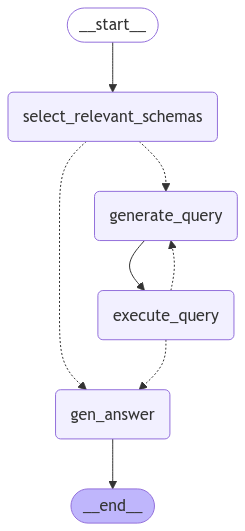

In [ ]:
from typing import Callable
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_community.utilities import SQLDatabase


class RelevantSchemasOutput(BaseModel):
    relevant_tables: List[str] = Field(description="List of relevant tables", default_factory=list)

MAX_ATTEMPTS_DEFAULT = 1
INVALID_QUESTION_ERROR = "The quesiton is not related to the database"
REACH_OUT_MAX_ATTEMPTS_ERROR = "The system reach out the attempts limits before get the information."


def create_select_schemas_agent(system_prompt: str, agent_name: str, parser: BaseModel, call_after_tool: bool = True):
    
    def agent(state, config):
        # Initialize the SQLDatabase object
        db = SQLDatabase.from_uri(state.db_url)
        state.max_attempts = state.max_attempts if state.max_attempts > 0 else MAX_ATTEMPTS_DEFAULT
        table_names = db.get_usable_table_names()
        question = state.question
        
        llm = load_model(model_name=state.llm_model_name)
        
        llm_with_struct = llm.with_structured_output(schema=parser)
        
        input = [
            SystemMessage(content=system_prompt.format(tables_names=table_names)),
            HumanMessage(content=question),
        ]

        response = invoke_chain_and_log(chain=llm_with_struct, input=input)

        relevant_tables = response.relevant_tables
        logger.info(f"{relevant_tables = }")

        if not relevant_tables:
            state.messages.append(SystemMessage(INVALID_QUESTION_ERROR))
            return state
        
        if isinstance(relevant_tables, list):
            relevant_tables = [item for item in relevant_tables if isinstance(item, str)]

        tables_info = db.get_table_info(relevant_tables)
        state.tables_info = tables_info
        state.attempts += 1
        return state

    return agent


class GenQueryResponse(BaseModel):
    statement: str = Field(description="Query statement to be run later in the DB")
    reasoning: str = Field(description="Reasoning used to define the query")

def create_generate_query_agent(system_prompt: str, agent_name: str, parser: BaseModel):
    
    def agent(state, config):
        logger.info("### generate_query ###")
        
        question = state.question
        tables_info = state.tables_info
        queries = state.queries
        
        if not queries:
            instructions = GENERATE_QUERY_INSTRUCTIONS.format(info=tables_info)
        else:
            instructions = FIX_QUERY_INSTRUCTIONS.format(info=tables_info, error_info=queries[-1].error_info)
            
        generator_prompt = [
            SystemMessage(content=instructions), 
            HumanMessage(content=question)]
        
        llm = load_model(model_name=state.llm_model_name)
        llm_with_struct = llm.with_structured_output(schema=parser)
        gen_response = llm_with_struct.invoke(generator_prompt)
        
        checker_prompt = [SystemMessage(content=QUERY_CHECK_INSTRUCTION), AIMessage(content=f"SQLite query: {gen_response.statement}\nReasoning: {gen_response.reasoning}")]
        checker = llm.with_structured_output(schema=parser)
        checker_response = checker.invoke(checker_prompt)
        
        was_corrected = gen_response.statement != checker_response.statement
        
        final_reasoning = (gen_response.reasoning +
                           "" if not was_corrected else f"First: {gen_response.reasoning}\nCorrection: {checker_response.reasoning}")
        
        query = Query(statement=checker_response.statement, reasoning=final_reasoning)
        logger.info(query.info)
        
        state.queries.append(query)
        return state
    
    return agent

def create_execute_query_agent(agent_name: str):
    
    def agent(state, config):
        logger.info("### execute_query ###")
        
        # Initialize the SQLDatabase object
        db = SQLDatabase.from_uri(state.db_url)
        
        attempts = state.attempts
        max_attempts = state.max_attempts
        
        logger.info(f"Attempt {attempts} of {max_attempts}")
        
        query = state.queries[-1]
        
        try:
            query.result = db.run(query.statement)
        
        except Exception as e:
            query.error = str(e)
            query.is_valid = False
            
            logger.info(query.error_info)
            
            if attempts >= max_attempts:
                logger.info(f"Reach out max attempts")
                state.error_message = REACH_OUT_MAX_ATTEMPTS_ERROR
                return state
        
        state.attempts += 1
        return state
    
    return agent

def create_gen_answer_agent(system_prompt: str, agent_name: str):
    
    def agent(state, config):
        logger.info("### gen_answer ###")
        
        if state.error_message:
            return state
        
        query = state.queries[-1]
        
        generate_answer_instruction = system_prompt.format(query_info=query.info)
        
        prompt = [SystemMessage(content=generate_answer_instruction), HumanMessage(content=state.question)]
        
        llm = load_model(model_name=state.llm_model_name)
        response = llm.invoke(prompt)
        
        state.answer = response.content
        return state
    
    return agent

SELECT_SCHEMAS = "select_relevant_schemas"
GENERATE_QUERY = "generate_query"
EXECUTE_QUERY = "execute_query"
GENERATE_ANSWER = "gen_answer"

select_relevant_schemas = create_select_schemas_agent(
    system_prompt=SELECT_RELEVANT_TABLES_INSTRUCTION,
    agent_name=SELECT_SCHEMAS,
    parser=RelevantSchemasOutput
    )

generate_query_agent = create_generate_query_agent(
    system_prompt=PromptTemplate(template=GENERATE_QUERY_INSTRUCTIONS, input_variables=["info"]),
    agent_name=GENERATE_QUERY,
    parser=GenQueryResponse
)

execute_query_agent = create_execute_query_agent(
    agent_name=EXECUTE_QUERY
)

gen_answer_agent = create_gen_answer_agent(
    system_prompt=PromptTemplate(template=GENERATE_ANSWER_INSTRUCTION, input_variables=["query_info"]),
    agent_name=GENERATE_ANSWER
)


def check_question(state) -> Literal[GENERATE_QUERY, GENERATE_ANSWER]:
    if state.error_message == INVALID_QUESTION_ERROR:
        return GENERATE_ANSWER
    return GENERATE_QUERY

def router(state) -> Literal[GENERATE_QUERY, GENERATE_ANSWER]:
    query = state.queries[-1]

    return GENERATE_ANSWER if query.result else GENERATE_QUERY

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

builder = StateGraph(AgentState)#, input=InputState, output=OutputState)
builder.add_node(SELECT_SCHEMAS, select_relevant_schemas)
builder.add_node(GENERATE_QUERY, generate_query_agent)
builder.add_node(EXECUTE_QUERY, execute_query_agent)
builder.add_node(GENERATE_ANSWER, gen_answer_agent)

builder.add_edge(START, SELECT_SCHEMAS)
builder.add_conditional_edges(SELECT_SCHEMAS, check_question)
builder.add_edge(GENERATE_QUERY, EXECUTE_QUERY)
builder.add_conditional_edges(EXECUTE_QUERY, router)
builder.add_edge(GENERATE_ANSWER, END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


# View
display(Image(graph.get_graph().draw_mermaid_png()))

 ### Run the Agent
Run the agent to answer a question:

In [10]:
import uuid
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

DATABASE_URL = 'sqlite:///./test.db'

def run_client(question="", max_attempts=1, config=config):
    print("### Start Client ###\n")

    state = AgentState(
        question=question,
        max_attempts=max_attempts,
        db_url=DATABASE_URL
    )

    response = graph.invoke(state, config)

    if answer := response.get("answer"):
        print("🙌", answer)
        return

    if error := response.get("error_message"):
        print("\n🙈", error)

In [21]:
run_client("How many people where on board the titanic ship?")

### Start Client ###

🙌 There were 891 people on board the Titanic ship.


In [ ]:
all_states = []
for state in graph.get_state_history(config):
    print(state)
    all_states.append(state)
    print("--")

StateSnapshot(values={'question': 'How many people where on board the titanic ship?', 'max_attempts': 1, 'attempts': 10, 'answer': 'There were 891 people on board the Titanic ship.', 'tables_info': '\nCREATE TABLE postgres_db_titanicdataset (\n\t"PassengerId" INTEGER GENERATED BY DEFAULT AS IDENTITY (INCREMENT BY 1 START WITH 1 MINVALUE 1 MAXVALUE 2147483647 CACHE 1 NO CYCLE), \n\t"Pclass" INTEGER NOT NULL, \n\t"Survived" INTEGER NOT NULL, \n\t"Name" VARCHAR(255) NOT NULL, \n\t"Sex" VARCHAR NOT NULL, \n\t"Age" DOUBLE PRECISION, \n\t"SibSp" INTEGER NOT NULL, \n\t"Parch" INTEGER NOT NULL, \n\t"Ticket" VARCHAR(20) NOT NULL, \n\t"Fare" DOUBLE PRECISION NOT NULL, \n\t"Cabin" VARCHAR(20), \n\t"Embarked" VARCHAR(1), \n\tCONSTRAINT postgres_db_titanicdataset_pkey PRIMARY KEY ("PassengerId")\n)\n\n/*\n3 rows from postgres_db_titanicdataset table:\nPassengerId\tPclass\tSurvived\tName\tSex\tAge\tSibSp\tParch\tTicket\tFare\tCabin\tEmbarked\n1\t0\t3\tBraund, Mr. Owen Harris\tmale\t22.0\t1\t0\tA/5 2

In [23]:
query = all_states[1].values['queries'][0].statement

In [24]:
result = db.run(query)
result

'[(891,)]'